In [ ]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../..")
# Importing GemPy
import gempy as gp
# Embedding matplotlib figures in the notebooks
%matplotlib inline
# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt


In [9]:
# set resolution, extent and input data
geo_data = gp.create_data([0,1000,0,50,0,1000],resolution=[50,1,50], 
                        path_o = os.pardir+"/data/input_data/jan_models/model1_orientations.csv",
                        path_i = os.pardir+"/data/input_data/jan_models/model1_surface_points.csv") 

Active grids: ['regular']


In [10]:
# define series and assign surfaces
gp.map_series_to_surfaces(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')})

,surface,series,order_surfaces,isBasement,color,id
0,rock2,Strat_Series,1,False,#015482,1
1,rock1,Strat_Series,2,False,#9f0052,2
2,basement,Basement_Series,1,True,#ffbe00,3


In [11]:
# define the interpolator
interp_data = gp.set_interpolation_data(geo_data, compile_theano=True,
                                        theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!


In [13]:
#calcualte the solution
sol = gp.compute_model(geo_data)

../..\gempy\core\solution.py:258: UserWarning: Surfaces not computed due to: marching_cubes_lewiner() got an unexpected keyword argument 'mask'
  warnings.warn('Surfaces not computed due to: ' + str(e))


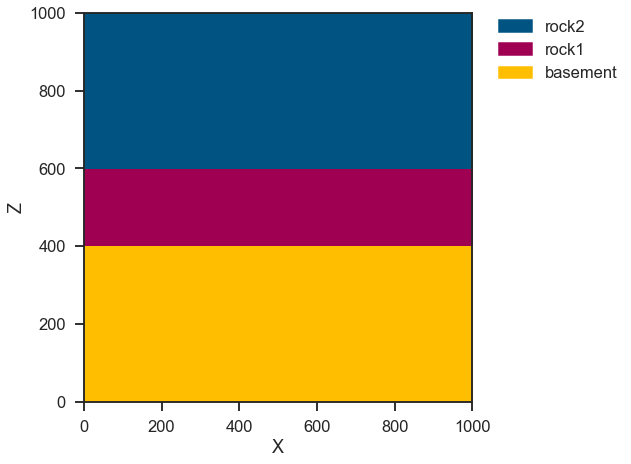

In [14]:
# Plot cross section, which is basically the whole model in this example
gp.plot.plot_section(geo_data, cell_number=0)

In [15]:
import gempy as gp
importlib.reload(kriging)

<module 'gempy.assets.kriging' from '../..\\gempy\\assets\\kriging.py'>

In [16]:
test_data = np.array([[110,0,510,2],[910,0,510,1],[510,0,530,1],[310,0,410,5]])

In [32]:
# Creating a kriging object with model solution and input domain (by id) and conditioning data
kriging_model = kriging.kriging_model(model=sol, domain=[2],data=test_data)

kriging_model.krig_grid = np.round(kriging_model.krig_grid,0)

# set some parameters, not final yet
kriging_model.range_ = 200
kriging_model.moving_neighbourhood  = 'all'
kriging_model.set_kriging_type('OK')
kriging_model.nugget = 2
kriging_model.sill = np.var(test_data[:,3])

kriging_model.create_kriged_field()

kriging_model.results_df.head()

,X,Y,Z,est_value,est_variance
0,10.0,0.0,410.0,2.287830,3.144759
1,10.0,0.0,430.0,2.283226,3.128987
2,10.0,0.0,450.0,2.277921,3.114867
3,10.0,0.0,470.0,2.272237,3.103669
4,10.0,0.0,490.0,2.266556,3.096867


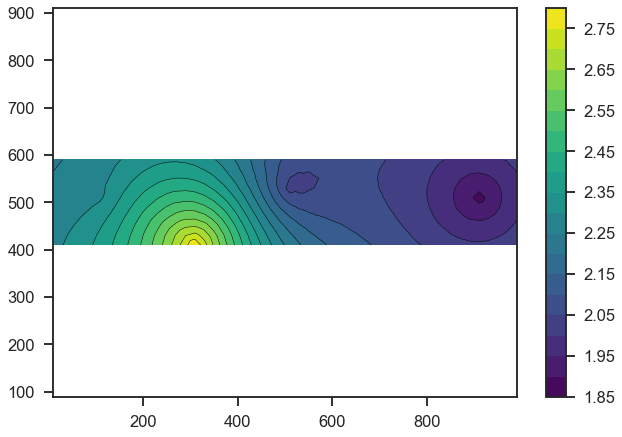

In [33]:
x = kriging_model.results_df['X'].values
y = kriging_model.results_df['Z'].values
prop = kriging_model.results_df['est_value'].values
var = kriging_model.results_df['est_variance'].values


fig1, ax1 = plt.subplots()
ax1.axis('equal')


tcf = ax1.tricontourf(x, y, prop, 20, cmap='viridis')
tcf_lines = ax1.tricontour(x, y, prop, 20, linewidths=0.5, colors='k')
fig1.colorbar(tcf)

plt.show()

In [36]:
# Creating a kriging object with model solution and input domain (by id) and conditioning data
#kriging_model = kriging.kriging_model(model=sol, domain=[2],data=test_data)

#kriging_model.krig_grid = np.round(kriging_model.krig_grid,0)

# change moving neighbourhood for simulation
kriging_model.moving_neighbourhood  = 'n_closest'


kriging_model.create_gaussian_field()

kriging_model.results_sim_df.head()

,X,Y,Z,sim_value,est_variance
0,650.0,0.0,470.0,3.121114,3.089526
1,230.0,0.0,410.0,4.208958,2.873021
2,910.0,0.0,430.0,2.173077,2.921382
3,10.0,0.0,450.0,2.480378,2.911834
4,590.0,0.0,530.0,2.406172,2.697007


In [35]:
# results_df and results_sim_df are basically all you need for plotting I guess (hope)
# (plus maybe the solution (sol) that I pass to the object)

# 2D section plotting:
# - as for gempy section
# - either value or variance
# - either results or simulation results (if calculated)
# - either contourf or block
# - plot on section of model (maybe change colors of background model)
# - allow to plot on subplot if thats not automatically possible

# 3D Plotting
# - Most useful and cool for first run would be block model
# - allow threshhold to show only certain blocks

# variogram/covariance function plotting (Jan)
# - easily plot used function 
# - show nugget range and sill 
# - allow to plot on subplot if thats not automatically possible
